# Simple Coordination Figures

In [1]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from agents.deterministic import detQ
from environments.Env_2StateSingh import TwoStateSingh as ENV

from utils import interact as ia
from utils import quiver as qv
from utils import histories as he

In [3]:
# test initialization
gamma = 0.9
beta = 500 / (1-gamma)
alpha = 0.01  

NOISE = 0.5

env = ENV(**dict(obs_noise=NOISE))
T, R, O = env.T, env.R, env.O
assert np.allclose(T.sum(-1), 1)
assert np.allclose(O.sum(-1), 1)

agents = detQ(T, R, O, alpha, beta, gamma)
print(f"Agent with parameters alpha={alpha}, beta={beta}, gamma={gamma}")

Agent with parameters alpha=0.01, beta=5000.000000000001, gamma=0.9


In [8]:
# functions

def get_agents(alpha, beta, gamma, noise, h=(1,0), Atype=detQ):
    env = ENV(obs_noise=noise)
    T = he.histSjA_TransitionTensor(env, h)
    R = he.histSjA_RewardTensor(env, h)
    O = he.histSjA_ObservationTensor(env, h)
    assert np.allclose(T.sum(-1), 1)
    assert np.allclose(O.sum(-1), 1)
    
    agents = Atype(T, R, O, alpha, beta, gamma)
    print(f"Agent with parameters alpha={alpha}, beta={beta}, gamma={gamma}")
    return agents
    
def getXs(agents, n=4, radius=0.3):
    """
    Get policies on a circle around the mean
    """
    Xs = [agents.zeroIntelligence_behavior()]
    x0 = 0.5; y0 = 0.5
    
    for phi in np.linspace(0, 2*np.pi, n)[0:-1]:
        X = agents.zeroIntelligence_behavior()
        X[0, 0, 0] = x0 + radius*np.cos(phi); X[0, 0, 1] = 1-X[0, 0, 0] 
        X[0, 1, 0] = y0 + radius*np.sin(phi); X[0, 1, 1] = 1-X[0, 1, 0]
        
        if X.shape[1] == 4:
            X[0, 2, :] = X[0, 1, :]; X[0, 3, :] = X[0, 0, :]; 
            
        Xs.append(X)
    return Xs

def compute_data(agents, NrX=5, radi=0.3):

    Xs = getXs(agents, n=5, radius=0.3) 
    Xtrajs = []; Rtrajs = []; fprs = []
    for i, X in enumerate(Xs):
        print(' ', i, end='')
        
        Xtraj, Rtraj, fpr = ia.compute_detXtraj(agents, X, EpsMin=1e-5, Tmax=1000)
        Xtrajs.append(Xtraj); Rtrajs.append(Rtraj); fprs.append(fpr)

    print()        
    return Xtrajs, Rtrajs, fprs

def _complot_agents(noise, cmap, alpha, beta, gamma, axPS, axTR, axTRin=None):
    pAs = np.linspace(0.02, 0.98, 9)
    x=([0], [0], [0]); y=([0], [1], [0])

    agents = get_agents(alpha, beta, gamma, noise=noise)
    Xtrajs, Rtrajs, fprs = compute_data(agents)

    cmap = matplotlib.cm.get_cmap(cmap)
    cols = [cmap(k) for k in np.linspace(0.1, 0.9, len(Xtrajs))] 

    axes= qv.plot_quiver(agents, x=x, y=y, diff="X",
                        pAs=pAs, NrRandom=8, kind="quiver+samples", dens=0.4,
                        sf=1.0, policies_iter_steps=0, axes=axPS, cmap='Greys')
    qv.plot_trajectories(Xtrajs, x, y, lss=["-"], lws=[2.5], cols=cols, 
                        alphas=[0.6], fprs=fprs,
                        axes=axPS)
    axPS.set_ylim(-0.01, 1.01); axPS.set_xlim(-0.01, 1.01)

    ## Reward Trajectories
    for k, Rtraj in enumerate(Rtrajs):
        axTR.plot(Rtraj[:, 0], color=cols[k], alpha=0.4)

        if axTRin is not None:
            axTRin.plot(Rtraj[:, 0], color=cols[k], alpha=0.4)
    return Xtrajs, Rtrajs, fprs

### Plot 1

Agent with parameters alpha=0.01, beta=400.0000000000001, gamma=0.9
  0  1  2  3  4
Agent with parameters alpha=0.01, beta=400.0000000000001, gamma=0.9
  0  1  2  3  4
Agent with parameters alpha=0.01, beta=400.0000000000001, gamma=0.9
  0  1  2  3  4
Agent with parameters alpha=0.01, beta=4000.000000000001, gamma=0.9
  0  1  2  3  4
Agent with parameters alpha=0.01, beta=4000.000000000001, gamma=0.9
  0  1  2  3  4
Agent with parameters alpha=0.01, beta=4000.000000000001, gamma=0.9
  0  1  2  3  4


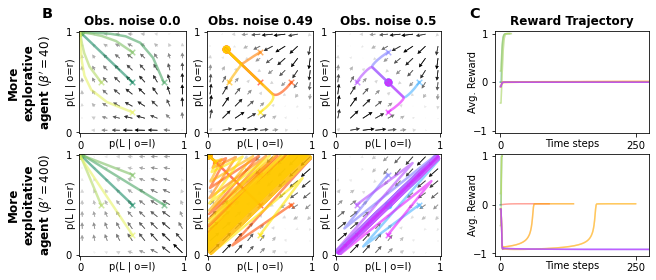

In [9]:
fsf = 0.65 # figure size scale factor
fig = plt.figure(figsize=(fsf*14, fsf*6.))

# outlining of axes
gs = fig.add_gridspec(1, 3, wspace=0.35, left=0.11, right=0.98,
                      top=0.90, bottom=0.10)

gsPS = gs[0:2].subgridspec(2,3)
gsTR = gs[2].subgridspec(2,1)

axPS1 = fig.add_subplot(gsPS[0, 0])
axPS2 = fig.add_subplot(gsPS[0, 1])
axPS3 = fig.add_subplot(gsPS[0, 2])
axTR = fig.add_subplot(gsTR[0])
axTRin = None
axPSb1 = fig.add_subplot(gsPS[1, 0])
axPSb2 = fig.add_subplot(gsPS[1, 1])
axPSb3 = fig.add_subplot(gsPS[1, 2])
axTRb = fig.add_subplot(gsTR[1])

# labeling and annotations
for ax in [axPS1, axPS2, axPS3, axPSb1, axPSb2, axPSb3]:
    ax.set_xlabel('p(L | o=l)', labelpad=-12)
    ax.set_ylabel('p(L | o=r)', labelpad=-10)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-0.05, 1.05)
    ax.set_yticks([0,1]); ax.set_xticks([0,1])
for ax in [axTR, axTRb]:
    ax.set_ylim([-1.05, 1.05])
    ax.set_yticks([-1, 0, 1])
    ax.set_ylabel('Avg. Reward', labelpad=-5)
    ax.set_xlim(-10, 275)
    ax.set_xticks([0, 250])
    ax.set_xlabel('Time steps', labelpad=-12)

axPS1.set_title('Obs. noise 0.0', weight='bold')
axPS2.set_title('Obs. noise 0.49', weight='bold')
axPS3.set_title('Obs. noise 0.5', weight='bold')
axTR.set_title('Reward Trajectory', weight='bold')

axPS1.annotate(f"More\nexplorative\nagent "+r"$(\beta'=40)$", xy=(-0.45,0.5),
               xycoords="axes fraction", color="k", weight='bold',
               rotation=90, ha="center", va="center", fontsize='large')

axPSb1.annotate(f"More\nexploitative\nagent "+r"$(\beta'=400)$", xy=(-0.45,0.5),
               xycoords="axes fraction", color="k", weight='bold',
               rotation=90, ha="center", va="center", fontsize='large')

axPS1.annotate(f"B", xy=(-0.25, 1.1), xycoords="axes fraction", color="k",
               ha="right", va="bottom", fontsize='x-large', weight='bold')

axTR.annotate(f"C", xy=(-0.1, 1.1), xycoords="axes fraction", color="k",
              ha="right", va="bottom", fontsize='x-large', weight='bold')


#
#   GENERATE DATA AND PLOT
#

# Low exploitation / high exploration
gamma = 0.9
beta = 40 / (1-gamma)
alpha = 0.01

_, Rt, fprs, = _complot_agents(noise=0.0, cmap='summer', axPS=axPS1, axTR=axTR,
                               alpha=alpha, beta=beta, gamma=gamma)

_complot_agents(noise=0.49, cmap='autumn', axPS=axPS2, axTR=axTR,
                alpha=alpha, beta=beta, gamma=gamma)

_, Rt, fprs = _complot_agents(noise=0.50, cmap='cool', axPS=axPS3, axTR=axTR,
                              alpha=alpha, beta=beta, gamma=gamma)


# # Low exploitation / high exploration
gamma = 0.9
beta = 400 / (1-gamma)
alpha = 0.01
_, Rt, fprs = _complot_agents(noise=0.0, cmap='summer', axPS=axPSb1, axTR=axTRb,
                              alpha=alpha, beta=beta, gamma=gamma)

_complot_agents(noise=0.49, cmap='autumn', axPS=axPSb2, axTR=axTRb,
                alpha=alpha, beta=beta, gamma=gamma)

Xt, Rt, fprs, = _complot_agents(noise=0.50, cmap='cool', axPS=axPSb3, axTR=axTRb,
                                alpha=alpha, beta=beta, gamma=gamma)

plt.savefig("figs/fig_SimpleCoordination.png", dpi=300, facecolor='w')

### Plot 2

Agent with parameters alpha=0.01, beta=4000.000000000001, gamma=0.9
  0  1  2  3  4


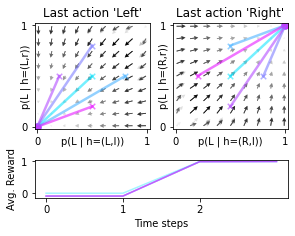

In [11]:
# Data
gamma = 0.9
beta = 400 / (1-gamma)
alpha = 0.01
agents = get_agents(alpha, beta, gamma, noise=0.5, h=(1,1))
Xtrajs, Rtrajs, fprs = compute_data(agents)

# Figure 
fsf = 0.8
fig = plt.figure(figsize=(fsf*5, fsf*4))

gs = fig.add_gridspec(3, 2, wspace=0.2, hspace=0.8, left=0.1, right=0.98,
                      top=0.9, bottom=0.14)
axPS1 = fig.add_subplot(gs[0:2, 0])
axPS2 = fig.add_subplot(gs[0:2, 1])
axTR = fig.add_subplot(gs[2, 0:2])

cmap = matplotlib.cm.get_cmap('cool')
cols = [cmap(k) for k in np.linspace(0.1, 0.9, len(Xtrajs))] 

pAs = np.linspace(0.01, 0.99, 9)
i=0; j=1
x1=([0], [i], [0]); y1=([0], [j], [0])
axes= qv.plot_quiver(agents, x=x1, y=y1, diff="X",
                     pAs=pAs, NrRandom=8, kind="quiver+samples", dens=0.4,
                     sf=1.0, policies_iter_steps=0, axes=axPS1, cmap='Greys')
qv.plot_trajectories(Xtrajs, x1, y1, lss=["-"], lws=[2.5], cols=cols, 
                     alphas=[0.6], fprs=fprs,
                     axes=axPS1)

h=he.hOset(env, (1,1))[0][i].replace('|', '').replace('o', 'l')
axPS1.set_xlabel(f'p(L | h=({h}))', labelpad=-10)

h=he.hOset(env, (1,1))[0][j].replace('|', '').replace('t', 'r')
axPS1.set_ylabel(f'p(L | h=({h}))', labelpad=-10) 

axPS1.set_title("Last action 'Left'")

i=2; j=3
x2=([0], [i], [0]); y2=([0], [j], [0])
axes= qv.plot_quiver(agents, x=x2, y=y2, diff="X",
                     pAs=pAs, NrRandom=8, kind="quiver+samples", dens=0.4,
                     sf=1.0, policies_iter_steps=0, axes=axPS2, cmap='Greys')
qv.plot_trajectories(Xtrajs, x2, y2, lss=["-"], lws=[2.5], cols=cols, 
                     alphas=[0.6], fprs=fprs,
                     axes=axPS2)

h=he.hOset(env, (1,1))[0][i].replace('|', '').replace('o', 'l')
axPS2.set_xlabel(f'p(L | h=({h}))', labelpad=-10)

h=he.hOset(env, (1,1))[0][j].replace('|', '').replace('t', 'r')
axPS2.set_ylabel(f'p(L | h=({h}))', labelpad=-10) 

axPS2.set_title("Last action 'Right'")

## Reward Trajectories
for k, Rtraj in enumerate(Rtrajs):
    axTR.plot(Rtraj[:, 0], color=cols[k], alpha=0.4)

axTR.set_xticks([0,1,2]);
axTR.set_xlabel("Time steps")
axTR.set_ylabel("Avg. Reward")

plt.savefig("figs/fig_SimpleCoordinationHistory.png", dpi=300, facecolor='w')